In [1]:
import numpy as np
from numpy import array, sin, cos, dot, random, zeros, ones, exp
from scipy.optimize import minimize, root
from scipy.linalg import solve, norm
from scipy.integrate import simps
from scipy.interpolate import lagrange
from math import pi
import sys
import matplotlib.pyplot as plt
from matplotlib import animation,rc
%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from control import lqr

## Mechanical System

In [46]:
#change here
#------------
Duration = 3;
FPS = 1000;
starting_point = array([0,0,0,0])
target_point = array([pi,0,0,0])
print_L = False
global_B = array([[1,0],[0,1]])#full actuated
global_B_dict={"full":array([[1,0],[0,1]]), "under": array([[0,0],[0,1]])}
#-----------
dt = 1./FPS
N = int(Duration*FPS);
friction = 0
g = 9.8

costs=[]

def acrobot_gradient(x, u):
    
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],[1+cos(x[1]), 1]])
    c1 = x[3]*(2*x[2]+x[3])*sin(x[1]) - 2*g*sin(x[0]) - g*sin(x[0]+x[1])
    c2 = -x[2]**2*sin(x[1]) - g*sin(x[0]+x[1])
    a = np.concatenate([x[2:4], solve(M,array([c1-friction*x[2], c2-friction*x[3]]))])
    bottom=solve(M,global_B)
    B = array([[0,0],
               [0,0],
               [bottom[0,0],bottom[0,1]],
               [bottom[1,0],bottom[1,1]]])
    #print(u.shape)
    xd = a + dot(B,u)
    return xd
    
def acrobot_next_step(x,u):
    
    xd = acrobot_gradient(x,u)
    #print (dt)
    new_x = x + xd*dt
    #limit angle range to [0, 2pi]
    #new_x[0]=new_x[0]%(2*pi)
    #new_x[1]=new_x[1]%(2*pi)
    #avoid acceleration overflow
    return new_x#np.clip(new_x,-100000,100000)

r=0.01
k=1
last_steps_bonus = 100
penalize_u1_factor = 1
def cost_function(x,u,i,n) : 
    if i >= (n-3):
        return r/2*(penalize_u1_factor*u[0]**2+u[1]**2) + 1 - last_steps_bonus*exp(-k*cos(x[0]) + k*cos(x[1])-2*k)
    else:
        return r/2*(penalize_u1_factor*u[0]**2+u[1]**2) + 1 - exp(-k*cos(x[0]) + k*cos(x[1])-2*k) 


#define partial derivation functions
def numerical_dfdxT(x,u):
    delta = 0.0001
    out = zeros([4,4])
    for i in range(4):
        delta_v = zeros(4)
        delta_v[i] = delta
        #print(x+delta_v)
        out[i] = ((acrobot_gradient(x+delta_v,u)-acrobot_gradient(x-delta_v,u))*dt+2*delta_v)/2/delta
    return out

def df_ddx(x,u):
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],
               [1+cos(x[1]),    1]
              ])
    C = array([[-2*sin(x[1])*x[3], -sin(x[1])*x[3]],
               [sin(x[1])*x[2],    0]
              ])
    dGdq = array([[g*(2*cos(x[0])+cos(x[0]+x[1])),g*cos(x[0]+x[1])],
                  [g*cos(x[0]+x[1]),              g*cos(x[0]+x[1])]
                 ])
    bottom_left = - solve(M,dGdq)
    bottom_right = - solve(M,C+np.identity(2)*friction)
    xd= array([[0,0,1,0],
                  [0,0,0,1],
                  [bottom_left[0,0],bottom_left[0,1],bottom_right[0,0],bottom_right[0,1]],
                  [bottom_left[1,0],bottom_left[1,1],bottom_right[1,0],bottom_right[1,1]]
                 ])
    return xd

def dfdxT(x,u):
    xd = df_ddx(x,u)
    x = xd*dt+np.identity(4)
    return x.T

def df_ddu(x,u):
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],[1+cos(x[1]), 1]])
    bottom=solve(M,global_B)
    B = array([[0,0],
               [0,0],
               [bottom[0,0],bottom[0,1]],
               [bottom[1,0],bottom[1,1]]])
    return B

def dfdu(x,u):
    return dt*df_ddu(x,u)


def dgdx(x,u,i,n):
    out = zeros(4)
    x1= x[0]
    x2= x[1]
    out[0] = -exp(-k*cos(x1)+k*cos(x2)-2*k)*k*sin(x1)
    out[1] = exp(-k*cos(x1)+k*cos(x2)-2*k)*k*sin(x2)
    
    if i >= (n-3):
        out *= last_steps_bonus
    return out
def dgdu(x,u):
    return r*array([u[0]*penalize_u1_factor,u[1]])


## Linearized System

In [59]:

def acrobot_linearized_system(relative_x=array([pi,0,0,0]), relative_u=0):
    A = df_ddx(relative_x, relative_u)
    B = df_ddu(relative_x, relative_u)
    return (A,B)
    
def linearized_cost_function_matrices(relative_x=array([pi,0,0,0]), relative_u=0):
    Q=array([[0.1*dt,0,0,0],[0,0.1*dt,0,0],[0,0,0,0],[0,0,0,0]])
    Qf = 10*Q
    R=array([[dt,0],[0,dt]])
    return (Q,R,Qf)

## LQR

In [60]:
from scipy.linalg import solve_continuous_are

def our_lqr(A,B,Q,R):    
    P = solve_continuous_are(A,B,Q,R)
    K = solve(R,dot(B.T,P))
    return K

def cost(x,u,Q,R):
    return dot((x-target_point),dot(Q,(x-target_point)))*dot(u,dot(R,u))

def end_cost(x,u,Qf):
    return dot((x-target_point),dot(Qf,(x-target_point)))

    
def total_cost(X,U,Q = None,R = None, Qf = None):
    
    Q1, R1, Qf1 = linearized_cost_function_matrices() 
    Q = Q1 if Q == None else Q
    R = R1 if R == None else R
    Qf = Qf1 if Qf == None else Qf
    c=0
    #print(X.shape[0])
    for i in range(X.shape[0]-1):
        c+=cost(X[i],U[i],Q,R)
    c+=end_cost(X[i],U[i],Qf)
    return c

def LQR(x_now = starting_point, relative_x=array([pi,0,0,0]), N=N, relative_u=array([0,0]),output_x=False):
    A,B=acrobot_linearized_system(relative_x, relative_u)
    Q, R, Qf = linearized_cost_function_matrices()
    
    K = our_lqr(A,B,Q,R)
    u = zeros([N,2])
    x = zeros([N+1,4])
    x[0] = x_now
    for j in range(N):
        u[j]=relative_u + dot(-K,x[j]- relative_x)
        x[j+1] = acrobot_next_step(x[j],u[j]) 
    if output_x:
        return (u, x)
    return u

u=LQR()

In [ ]:
uu=u

## Iterative LQR

In [115]:
def iLQR_init():
    A,B=acrobot_linearized_system()
    Q, R, Qf = linearized_cost_function_matrices()
    K = our_lqr(A,B,Q,R)
    x = zeros([N+1,4])
    x[0] = starting_point
    x_reference = array([pi,0,0,0])
    u = zeros([N,2])
    for j in range(N):
        u[j]=dot(-K,x[j]- x_reference)

        x[j+1] = (x[j]+(dot(A,x[j]-x_reference)+dot(B,u[j]))*dt)#
    return (u, x)

# Only work for small disturbance
def iLQR(threshold = 1e-4,loop_limit=20):
    #generate initial u and x through regular LQR
    u_hat, x_hat = iLQR_init()
    step = 1
    cost = float("Inf")
    for loop in range(loop_limit):
        u_new = np.copy(u_hat)
        x_new = np.copy(x_hat)

        for i in range(N):
            u_new[i] = LQR(x_now = x_new[i], relative_x=x_hat[i], N=1, relative_u=u_hat[i])
        #for j in range(N-1):
            x_new[i+1] = acrobot_next_step(x_new[i],u_new[i])
        print(loop_limit)
        
        cost_now = total_cost(x_new,u_new)
        print(cost_now)
        if cost_now <= cost:
            if cost-cost_now < threshold:
                break
            u_hat = u_new
            x_hat = x_new
            cost = cost_now
        else:
            break
    print(x_new[-1])

    return u_new

# following Tassa 2012 paper
def iLQR2(threshold = 1e-15,loop_limit=100):
    #generate initial u and x through regular LQR
    u_hat, x_hat = iLQR_init()
    u_hat = random.normal(0,size=[N,2])#zeros([N,2])
    x_hat = simulation(starting_point,u_hat)
    lamb = 1
    cost = float("Inf")
    recalculate_path = True
    for loop in range(loop_limit):
        if recalculate_path:
            f_x = np.zeros((N, 4,4)) 
            f_u = np.zeros((N, 4,2)) 
            l = np.zeros((N,1))
            l_x = np.zeros((N, 4)) 
            l_xx = np.zeros((N, 4, 4)) 
            l_u = np.zeros((N, 2))
            l_uu = np.zeros((N, 2, 2)) 
            l_ux = np.zeros((N, 2, 4))

            for t in range(N-1):
                f_x[t] = df_ddx(x_hat[t], u_hat[t])*dt+np.identity(4)
                f_u[t] = dfdu(x_hat[t], u_hat[t])
                l[t] = (dot(x_hat[-1]-array([pi,0,0,0]),x_hat[-1]-array([pi,0,0,0]))+dot(u_hat[t],u_hat[t]))*dt
                l_x[t] =2*x_hat[t]*dt
                l_xx[t] = 2*np.identity(4)*dt
                l_u[t] =2*u_hat[t]*dt
                l_uu[t] = 2*np.identity(2)*dt
            l[-1] = np.sum((x_hat[-1]-array([pi,0,0,0]))**2)
            #print(l_x[-1])
            l_x[-1] = 2*(x_hat[-1]-array([pi,0,0,0]))
            l_xx[-1] = 2*np.eye(4)
            recalculate_path = False

        V = l[-1].copy() 
        V_x = l_x[-1].copy() 
        V_xx = l_xx[-1].copy()
        print("v:%d"%(V))
        k = np.zeros((N, 2)) 
        K = np.zeros((N, 2, 4)) 
        print((V_x))
        print((V_xx))
        
        for t in range(N-2, -1, -1):

            Q_x = l_x[t] + np.dot(f_x[t].T, V_x) 
            Q_u = l_u[t] + np.dot(f_u[t].T, V_x)
            Q_xx = l_xx[t] + np.dot(f_x[t].T, np.dot(V_xx, f_x[t])) 
            Q_ux = l_ux[t] + np.dot(f_u[t].T, np.dot(V_xx, f_x[t]))
            Q_uu = l_uu[t] + np.dot(f_u[t].T, np.dot(V_xx, f_u[t]))
            Q_uu_evals, Q_uu_evecs = np.linalg.eig(Q_uu)
            Q_uu_evals[Q_uu_evals < 0] = 0.0
            Q_uu_evals += lamb
            Q_uu_inv = np.dot(Q_uu_evecs, 
                    np.dot(np.diag(1.0/Q_uu_evals), Q_uu_evecs.T))
            k[t] = -np.dot(Q_uu_inv, Q_u)
            K[t] = -np.dot(Q_uu_inv, Q_ux)
            V_x = Q_x - np.dot(K[t].T, np.dot(Q_uu, k[t]))
            V_xx = Q_xx - np.dot(K[t].T, np.dot(Q_uu, K[t]))
        u_new = np.copy(u_hat)
        x_new = np.copy(x_hat)
        
        for i in range(N):
            u_new[i] = u_hat[i] + k[i] + np.dot(K[i], x_new[i] - x_hat[i]) 
            x_new[i+1] = acrobot_next_step(x_new[i],u_new[i])
        # evaluate the new trajectory 
        cost_now = total_cost(x_new,u_new,Q=zeros([4,4])*dt,Qf=np.eye(4),R=np.eye(2)*dt)
        print(cost_now)
        print(cost)
        if cost_now <= cost:
            lamb/=10
            u_hat = u_new
            x_hat = x_new
            #print(u_hat[0:10,:])
            recalculate_path = True
            print("new path")
            if (cost-cost_now)/cost_now < threshold:
                break
            cost = cost_now
            
        else:
            lamb*=10
            

    return u_hat,x_hat

#global_B = global_B_dict["under"]
#u,x_hat=iLQR2()

# Lagrangian Methods

## Lagrangian Bruteforce

In [ ]:
#brute force method, not converging

def lagrangian(input_array):
    #x is x1 to xN,followed by U0 to UN-1, followed by lambda0 to lambdaN-1
    x = np.concatenate([starting_point,input_array[:(N-1)*4]])
    u = input_array[(N-1)*4:(N-1)*4+N]
    lam = input_array[(N-1)*4+N:-1]

    L=0
    for i in range(N-1):
        #current x
        xx = x[i*4:(i+1)*4]
        #next x
        xx_p1 = x[(i+1)*4:(i+2)*4]
        #difference between x+dt*dx and x_next
        delta = xx+dt*acrobot_motion(xx,u[i])-xx_p1
        #minimize energy
        cost = cost_function(xx,u[i])
        lagragian_term = lam[i]*(delta[0:1]%(2*pi))
        L+=cost+lagragian_term
    return L
def lagrangian_train():
    init = np.ones(N*4+N+N)
    out = minimize(lagrangian,init)

## Lagrangian multiplier derivation

In [104]:
def grad_lagrangian_trick(u):
    # u is a vector of u0 to uN-1
    n=len(u)//2
    
    u=np.reshape(u,[n,2])
    x = zeros([n+1,4])
    x[0]=starting_point
    lam = zeros([n,4])
    lam[n-1] = zeros(4)
    dldu = zeros([n,2])
    
    #calculate gradient through back propagation
    for i in range(n):
        x[i+1]=acrobot_next_step(x[i],u[i])
        
    for i in reversed(range(1,n)):
        lam[i-1]=dgdx(x[i],u[i],i,n)+dot(dfdxT(x[i],u[i]),lam[i])
    
    for i in range(n):
        dldu[i]=dgdu(x[i],u[i])+dot(lam[i],dfdu(x[i],u[i]))
    
    return np.reshape(dldu,n*2)

def lagrangian_root_train(dt,N):
    u = zeros([N*2])#random.normal(0,size=N)
    #print(u.shape)
    out = root(grad_lagrangian_trick,u) 
    print(lagrangian_trick(out.x))
    return (out,out.x.reshape([N,2]))

def lagrangian_trick(u):
    #x is x1 to xN,followed by U0 to UN-1, followed by lambda0 to lambdaN-1
        # u is a vector of u0 to uN-1
    n=len(u)//2
    
    u=np.reshape(u,[n,2])
    x = zeros([n+1,4])
    x[0]=starting_point
    lam = zeros([n,4])
    lam[n-1] = zeros(4)
    
    
    #calculate gradient through back propagation
    for i in range(n):
        x[i+1]=acrobot_next_step(x[i],u[i])
        
    for i in reversed(range(1,n)):
        lam[i-1]=dgdx(x[i],u[i],i,n)+dot(dfdxT(x[i],u[i]),lam[i])

    L=0
    U=0
    for i in range(n):
        #current x
        xx = x[i]
        #next x
        xx_p1 = x[i+1]
        #difference between x+dt*dx and x_next
        delta = xx+dt*acrobot_gradient(xx,u[i])-xx_p1
        #minimize energy
        cost = cost_function(xx,u[i],i,n)
        lagragian_term = dot(lam[i],delta)
        L+=cost#+lagragian_term
        U+= dot(u[i],u[i])
    if print_L: print("L: "+str(L)+" U:"+str(r/2*U))
    costs.append(L)
    return L

def lagrangian_BFGS_train(dt,N,normal_seed=True,u=None):
    if u == None:
        u = random.normal(0,size=N*2) if normal_seed else zeros([N*2])
    #print(u.shape)
    out = minimize(lagrangian_trick,u,jac=grad_lagrangian_trick,options={"disp":True}) 
    return (out,out.x.reshape([N,2]))
def lagrangian_trick_train():
    init = np.ones(N*2)
    out = minimize(lagrangian_trick,init)
    return (out,out.x.reshape([N,2]))

## Chebyshev

In [102]:
def interpolate_fit(x, coef):
    f = lambda x : sum([pow(x, y)*coef[y] for y in range(len(coef))])
    vfunc = np.vectorize(f)
    return vfunc(x)

def interpolate_grad_fit(x, cheby_t, cheby_u):
    # fit gradient of model relate to cheby u
    # dL(t)dwj = lj(t) = (x-x0)/(xj-x0)....x-xk)/(xj-xk)
    f = lambda x : array(
        [
            np.prod([
                (x-xi)/(xj-xi) 
                for xi in cheby_t if xi!=xj
            ]) 
            for xj in cheby_t
        ]
    )
    return array([f(xx) for xx in x])
    
def chebyshev_gradient(ts,order,cheby_t,cheby_u):

    #calculate u according to current chebyshev
    u = zeros([len(ts),2])
    cheby_u = cheby_u.reshape([order,2])
    poly1 = np.flipud(lagrange(cheby_t,cheby_u[:,0]))
    u[:,0] = interpolate_fit(ts, poly1)
    poly2 = np.flipud(lagrange(cheby_t,cheby_u[:,1]))
    u[:,1] = interpolate_fit(ts, poly2)
    # calculate dLdw
    dldu = grad_lagrangian_trick(u.reshape(len(ts)*2)).reshape([len(ts),2])
    dudw1 = interpolate_grad_fit(ts, cheby_t, cheby_u[:,0])
    dudw2 = interpolate_grad_fit(ts, cheby_t, cheby_u[:,1])
    return array([[simps(dudw1[:,i]*dldu[:,0],ts),simps(dudw2[:,i]*dldu[:,1],ts)] for i in range(order)]).reshape(order*2)

def chebyshev_cost(ts,order,cheby_t,cheby_u):

    #calculate u according to current chebyshev
    cheby_u = cheby_u.reshape([order,2])
    poly1 = np.flipud(lagrange(cheby_t,cheby_u[:,0]))
    poly2 = np.flipud(lagrange(cheby_t,cheby_u[:,1]))
    u = np.concatenate([interpolate_fit(ts, poly1),interpolate_fit(ts, poly2)])
    # calculate dLdw
    return lagrangian_trick(u)

def chebyshev_root_train(dt,N,order):
    chebyshev = lambda n: array([cos((2*j-1)*pi/(2*n)) for j in range(1,n+1)])
    Duration = N*dt
    ts = np.arange(N)*dt
    cheby_t = (chebyshev(order)+1)*Duration/2
    cheby_u = random.normal(0,size=order*2)
    
    local_chebyshev_gradient = lambda cheby_u: chebyshev_gradient(ts,order,cheby_t,cheby_u)
    out = root(local_chebyshev_gradient,cheby_u)
    
    #get final u array
    cheby_u = out.x.reshape([order,2])
    u = zeros([N,2])
    poly1 = np.flipud(lagrange(cheby_t,cheby_u[:,0]))
    u[:,0] = interpolate_fit(ts, poly1)
    poly2 = np.flipud(lagrange(cheby_t,cheby_u[:,1]))
    u[:,1] = interpolate_fit(ts, poly2)
    return (out,u)

def chebyshev_BFGS_train(dt,N,order):
    chebyshev = lambda n: array([cos((2*j-1)*pi/(2*n)) for j in range(1,n+1)])
    Duration = N*dt
    ts = np.arange(N)*dt
    cheby_t = (chebyshev(order)+1)*Duration/2
    cheby_u = random.normal(0,size=order*2)
    
    local_chebyshev_gradient = lambda cheby_u: chebyshev_gradient(ts,order,cheby_t,cheby_u)
    local_chebyshev_cost = lambda cheby_u: chebyshev_cost(ts,order,cheby_t,cheby_u)
    out = minimize(local_chebyshev_cost,cheby_u,jac=local_chebyshev_gradient)
    
    #get final u array
    cheby_u = out.x.reshape([order,2])
    u = zeros([N,2])
    poly1 = np.flipud(lagrange(cheby_t,cheby_u[:,0]))
    u[:,0] = interpolate_fit(ts, poly1)
    poly2 = np.flipud(lagrange(cheby_t,cheby_u[:,1]))
    u[:,1] = interpolate_fit(ts, poly2)
    return (out,u)

## Fit

In [ ]:
#reset costs
costs=[]
#out = chebyshev_root_train(dt,N,3) 
#out = lagrangian_root_train(dt,N)
out = lagrangian_BFGS_train(dt,N)
#out = chebyshev_BFGS_train(dt,N,20) 
#out = lagrangian_trick_train()
u = out[1]


## Simulation

In [112]:
#u = zeros(N)
def simulation(starting_point,u,round_off=True):
    x = np.zeros((N+1, 4))
    
    x[0] = starting_point
    for i in range(N-1):
        x[i+1] = acrobot_next_step(x[i], u[i])
        if round_off:
            x[i+1][0]=x[i+1][0]%(2*pi)
            x[i+1][1]=x[i+1][1]%(2*pi)
    return x

x = simulation(starting_point,u)

## Animation

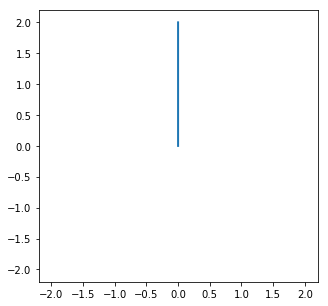

In [114]:

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(5,5))

ax.set_xlim(( -2.2, 2.2))
ax.set_ylim((-2.2, 2.2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(k):
    x1 = cos(x[k,0]-pi/2);
    y1 = sin(x[k,0]-pi/2);
    x2 = x1 + cos(x[k,0]+x[k,1]-pi/2);
    y2 = y1 + sin(x[k,0]+x[k,1]-pi/2);

    xs = [0, x1, x2]
    ys = [0, y1, y2]
    line.set_data(xs, ys)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N, interval=20, blit=True)
HTML(anim.to_html5_video())

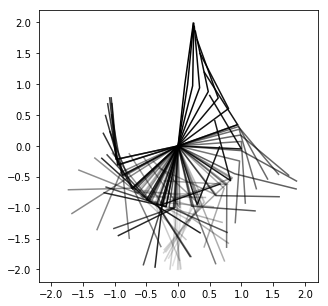

In [98]:
fig = plt.figure(figsize=(5,5))

plt.xlim(( -2.2, 2.2))
plt.ylim((-2.2, 2.2))

plot_until = N

# animation function. This is called sequentially
for k in range(0,plot_until,FPS//10):
    x1 = cos(x[k,0]-pi/2);
    y1 = sin(x[k,0]-pi/2);
    x2 = x1 + cos(x[k,0]+x[k,1]-pi/2);
    y2 = y1 + sin(x[k,0]+x[k,1]-pi/2);

    xs = [0, x1, x2]
    ys = [0, y1, y2]
    plt.plot(xs,ys,'k',alpha = (k+FPS/2)/(plot_until+FPS/2))
    #plt.scatter(xs,ys,alpha = (k+FPS)/(plot_until+FPS))

## Plot

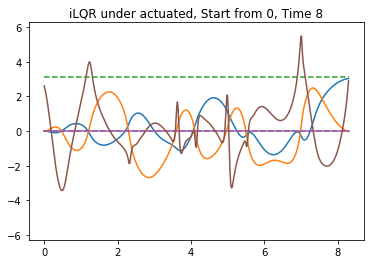

In [111]:
def plot(title):
    ts = np.arange(N)*dt
    plt.plot(ts,x[:,0][:N],label="q1")
    plt.plot(ts,x[:,1][:N],label="q2")
    plt.plot(ts,ones(N)*pi,"--",label="q1 optimal")
    plt.plot(ts,zeros(N),"--",label="q2 optimal")
    plt.plot(ts,u[:,0],label="u1")
    plt.plot(ts,u[:,1],label="u2")
    #plt.legend()
    plt.ylim([-2*pi,2*pi])
    plt.title(title)
    plt.show()
plot("iLQR under actuated, Start from 0, Time 8")

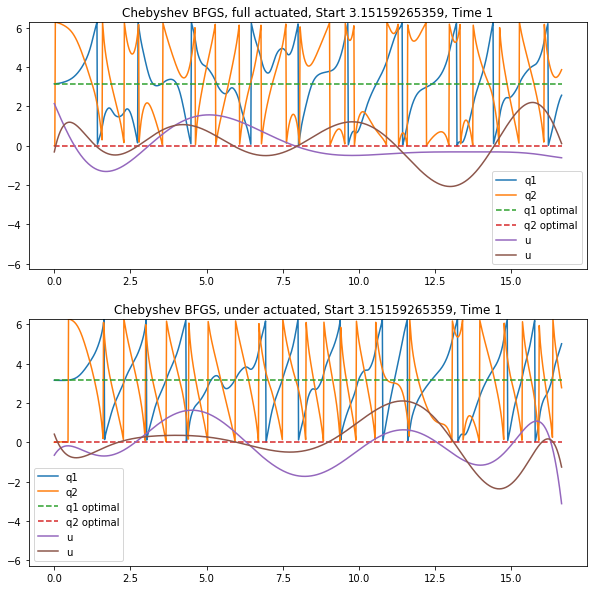

In [106]:
# Chebyshev plot
conditions = [array([0.01+pi,0,0,0]),array([0.01+pi,0,0,0])]
durations = [1,1]
FPS = 1000
full_actuated = ["full","under"]
fig, axes = plt.subplots(len(conditions), figsize=(10,10))
for i in range(len(conditions)):
        Duration = durations[i]
        starting_point = conditions[i]
        global_B = global_B_dict[full_actuated[i]]
        N = int(Duration*FPS)
        ts = np.arange(N)*dt
        u=chebyshev_BFGS_train(dt,N,10)[1]
        x = np.zeros((N, 4))
        x[0] = starting_point
        x = simulation(starting_point,u)
        
        axes[i].set_ylim([-2*pi,2*pi])
        axes[i].plot(ts,x[:,0][:N],label="q1")
        axes[i].plot(ts,x[:,1][:N],label="q2")
        axes[i].plot(ts,ones(N)*pi,"--",label="q1 optimal")
        axes[i].plot(ts,zeros(N),"--",label="q2 optimal")
        axes[i].plot(ts,u,label="u")
        axes[i].legend()
        axes[i].set_title("Chebyshev BFGS, "+full_actuated[i]+" actuated, Start "+str(starting_point[0])+", Time "+str(Duration))


In [ ]:
# Lagrangian plot
conditions = [array([0.01+pi,0,0,0]),array([0.1,0,0,0])]
durations = [1,2]
full_actuated = ["full","under"]
fig, axes = plt.subplots(len(conditions), figsize=(10,10))
for i in range(len(conditions)):
        Duration = durations[i]
        starting_point = conditions[i]
        global_B = global_B_dict[full_actuated[i]]
        N = int(Duration*FPS)
        ts = np.arange(N)*dt
        u=lagrangian_BFGS_train(dt,N)[1]
        x = np.zeros((N, 4))
        x[0] = starting_point
        x = simulation(starting_point,u)
        
        axes[i].set_ylim([-2*pi,2*pi])
        axes[i].plot(ts,x[:,0][:N],label="q1")
        axes[i].plot(ts,x[:,1][:N],label="q2")
        axes[i].plot(ts,ones(N)*pi,"--",label="q1 optimal")
        axes[i].plot(ts,zeros(N),"--",label="q2 optimal")
        axes[i].plot(ts,u,label="u")
        axes[i].legend()
        axes[i].set_title("Lagrangian BFGS, "+full_actuated[i]+" actuated, Start "+str(starting_point[0])+", Time "+str(Duration))


In [ ]:
# No control plot
conditions = [array([0.01+pi,0,0,0]),array([0.1,0,0,0])]
durations = [1,2]
full_actuated = ["full","under"]
fig, axes = plt.subplots(len(conditions), figsize=(10,10))
for i in range(len(conditions)):
        Duration = durations[i]
        starting_point = conditions[i]
        global_B = global_B_dict[full_actuated[i]]
        N = int(Duration*FPS)
        ts = np.arange(N)*dt
        u=np.zeros([N,2])
        x = np.zeros((N, 4))
        x[0] = starting_point
        x = simulation(starting_point,u)
        
        axes[i].set_ylim([-2*pi,2*pi])
        axes[i].plot(ts,x[:,0][:N],label="q1")
        axes[i].plot(ts,x[:,1][:N],label="q2")
        axes[i].plot(ts,ones(N)*pi,"--",label="q1 optimal")
        axes[i].plot(ts,zeros(N),"--",label="q2 optimal")
        axes[i].plot(ts,u,label="u")
        axes[i].legend()
        axes[i].set_title("No Control, "+full_actuated[i]+" actuated, Start "+str(starting_point[0])+", Time "+str(Duration))


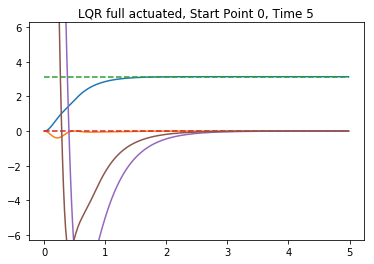

In [113]:
# LQR plot
Duration = 5
dt = 1.0/FPS
starting_point = array([0,0,0,0])
global_B = array([[1,0],[0,1]])#full actuated
#--------
N = int(Duration*FPS)
ts = np.arange(N)*dt

u=LQR(x_now = starting_point, N=N)
x[0] = starting_point
x = simulation(starting_point,u,False)
plot("LQR full actuated, Start Point "+str(starting_point[0])+", Time "+str(Duration))

## Cost function visualization

In [ ]:
grid = 100
contour_points = np.zeros([100,100])
contour_x = np.linspace(0,2*pi,100)
contour_y = np.linspace(0,2*pi,100)
for x in range(grid):
    for y in range(grid):
        xx=contour_x[x]
        yy=contour_y[y]
        contour_points[y][x]=cost_function([xx,yy],[0,0],0,7)
plt.figure(figsize=(6, 6))
CS=plt.contour(contour_x,contour_y,contour_points,20)
plt.clabel(CS, inline=1, fontsize=10)
plt.title("Cost Distribution")
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

## Cost Visualization of Lagrangian methods

In [ ]:
plt.plot(np.log(costs))
plt.title("log costs over time, full actuated BFGS")
plt.xlabel("iteration")
plt.ylabel("log(L)")
plt.show()

## iLQR

For under-actuated systems, LQR seems to only work near the optimal point due to the use of linearization. To solve the under-actuated swing up problem, we followed the iterative LQR method discussed by Tassa et al in 2012. The method first initialize a sequence of u and corresponding x, then defined Q as the change of cost relate to u and x near each point.

$Q(\partial x, \partial u) = cost(x_i+\partial x, u_i+ \partial u)-cost(x_i, u_i)+V(f(x_i+\partial x, u_i+ \partial u))-V(f(x_i,u_i))$

where V is the minimum total cost for following steps.

$V(x_i) = min_u\sum_{j=i}^Ncost(x_j,u_j)$

Then, use back propagation to solve at each step

$k(i) = Q_{uu}^{-1}Q_u$

$K(i) = Q_{uu}^{-1}Q_{ux}$

At last, go through another forward pass to get a new u sequence

$x_{new}(1)=x(1)$

$u_{new}(i)=u(i)+k(i)+K(i)(x_{new}(i)-x(i))$

$x_{new}(i+1)=f(x_{new}(i),u_{new}(i))$

Then iterate the process until total cost converges.